In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
# 0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

--2023-03-28 15:12:49--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-03-28 15:12:49 ERROR 403: Forbidden.



In [ ]:
# Run the cell above if you are downloading the data for the first time, however there is a problem with it
# It is better to download the data manually from the corresponding FCC challenges page and put it in the same
# folder with your notebook file 

In [2]:
#!unzip cats_and_dogs.zip  # Again un-comment to unzip the data for the first time 

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.

batch_size = 128
epochs = 15

IMG_HEIGHT = 150
IMG_WIDTH = 150

## The instructions in the [link](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/cat-and-dog-image-classifier) is pretty clear to pre-process the data and to build the CNN MODEL in order to pass this challenge 

In [3]:
# Pre-process the images using ImageDataGenerator of keras 
# by scaling their pixel values (from 0 to 255) to 0-1 range 

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory('cats_and_dogs/train', target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory('cats_and_dogs/validation', target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

# Do not shuffle test data to make sure the final predictions of our model stay in the order that our test expects
# classes = ['test'] is important to make the method understand we have effectively one 'class' in this category
# i.e without labels 
test_data_gen = test_image_generator.flow_from_directory(directory=r"cats_and_dogs/", classes=['test'],
        target_size=(150, 150), batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


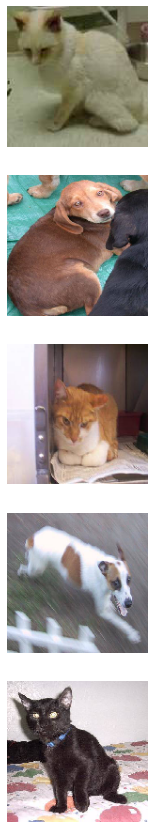

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip( images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip( images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# To get better results we augment the data by applying different transformation to each image

In [5]:
train_image_generator = ImageDataGenerator(rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.1, 
                                           zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2, rescale=1./255)

In [ ]:
# Following line will show different transformation applied to a single image 

Found 2000 images belonging to 2 classes.


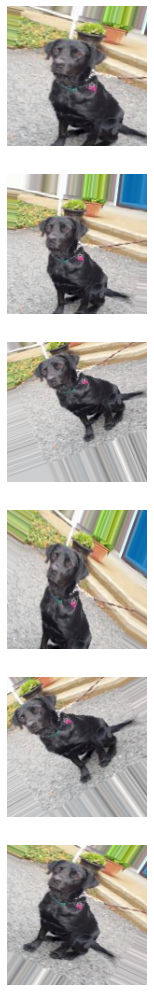

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(6)]

plotImages(augmented_images)

In [ ]:
# Build the CNN model using MaxPooling 

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2))

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 147968)            0

In [ ]:
# Train the model 

In [10]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

Epoch 1/15
15/15 [==============================] - 31s 2s/step - loss: 1.3798 - accuracy: 0.5027 - val_loss: 0.6909 - val_accuracy: 0.5067
Epoch 2/15
15/15 [==============================] - 29s 2s/step - loss: 0.6947 - accuracy: 0.5128 - val_loss: 0.6906 - val_accuracy: 0.5056
Epoch 3/15
15/15 [==============================] - 29s 2s/step - loss: 0.6966 - accuracy: 0.4941 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 4/15
15/15 [==============================] - 27s 2s/step - loss: 0.6897 - accuracy: 0.5112 - val_loss: 0.6830 - val_accuracy: 0.4955
Epoch 5/15
15/15 [==============================] - 27s 2s/step - loss: 0.6880 - accuracy: 0.5385 - val_loss: 0.6828 - val_accuracy: 0.4955
Epoch 6/15
15/15 [==============================] - 27s 2s/step - loss: 0.6803 - accuracy: 0.5406 - val_loss: 0.6580 - val_accuracy: 0.5848
Epoch 7/15
15/15 [==============================] - 29s 2s/step - loss: 0.6654 - accuracy: 0.5969 - val_loss: 0.6329 - val_accuracy: 0.6250
Epoch 8/15
15/15 [==

In [ ]:
# Plot and compare accuracy and loss in the training and validation set

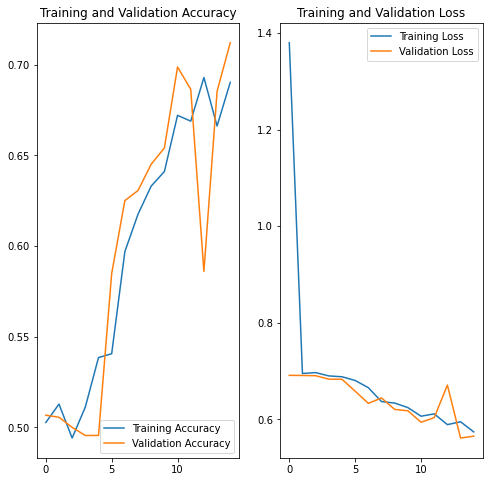

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
test_images, _ = next(test_data_gen)

In [90]:
# model.predict(test_data_gen) gives the probabilities in a un-normalized manner for a given image to be cat or dog
# it is a 50,2 array each row contains the prediction of likelihood of that image to be a cat or dog

In [ ]:
# We can extract the prediction as a cat or dog using argmax as each row has two index 0 and 1
# 0 being cat and 1 corresponding to dog

In [108]:
our_predictions = np.argmax(model.predict(test_data_gen), axis = -1)

1/1 [==============================] - 0s 277ms/step


In [109]:
print(our_predictions)

[0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 0 1]


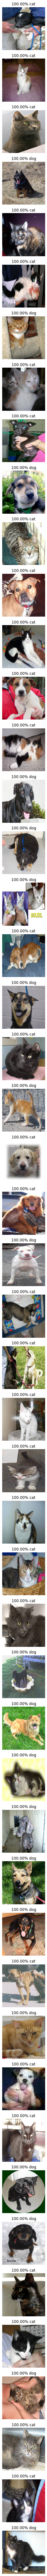

In [116]:
# Use plotImages function to plot test images together with our predictions 

plotImages(test_images, probabilities=our_predictions)

In [110]:
#actual labels of the test images
actual_labels =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

print(actual_labels)

[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]


In [115]:
#actual labels of the test images
actual_labels =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

# Count the number of times we labelled the image correctly and identify a percentile for it

correct = 0

for prediction, actual_label in zip(our_predictions, actual_labels):
    if  prediction == actual_label:
        correct +=1

percentage_identified = (correct / len(actual_labels)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
